In [1]:
import os
import time
import sys

import numpy as np
import pylab as plt
import matplotlib as mpl
from scipy import stats

# import pymc3 as pm
# import theano.tensor as tt

import pymc as pm
import pytensor.tensor as tt
from scipy.signal import savgol_filter

sys.path.append('/media/bigdata/firing_space_plot/ephys_data/')
import visualize as vz

## Generate synthetic data

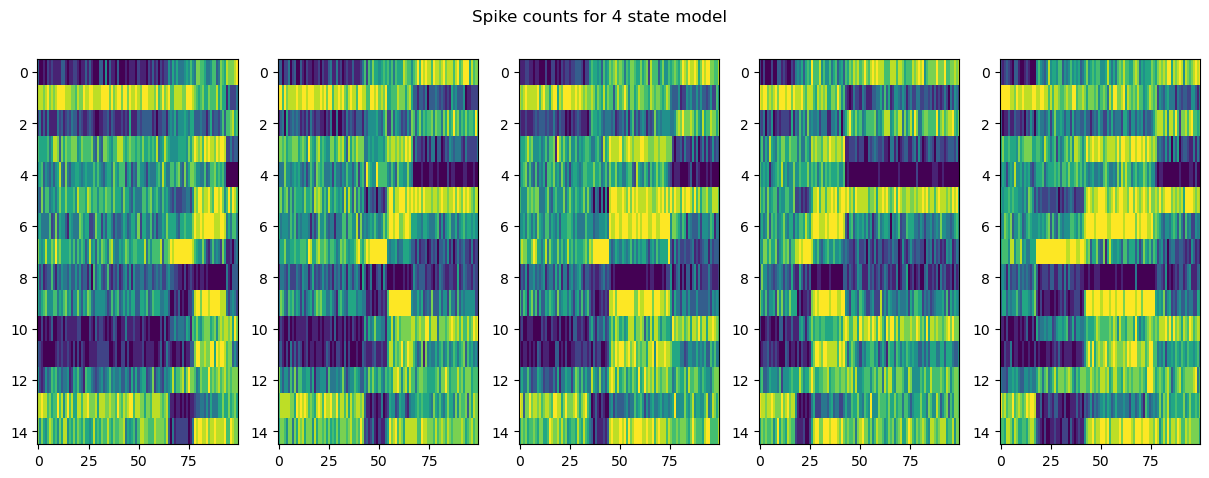

In [4]:
# Some poisson spiking
length = 1000
bin_width = 10
states = 4
nrns = 15
tastes = 4
trials = 20
idx = np.arange(length)

#true_tau = np.cumsum(np.random.random((tastes,trials,states)),axis=-1)
true_tau = np.cumsum(np.random.uniform(2,30, size = (tastes,trials,states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[...,np.newaxis]
true_tau *= length
true_tau = np.vectorize(int)(true_tau)

state_inds = np.concatenate([np.zeros((tastes,trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(int)(state_inds)

true_lambda = np.random.random((tastes,nrns,states))

true_r = np.zeros((tastes,trials, nrns, length))

for taste in range(tastes):
    for trial_num in range(trials):
        for state_num in range(states):
            true_r[taste,trial_num,:,state_inds[taste,trial_num,state_num]:state_inds[taste,trial_num,state_num+1]] = \
                            true_lambda[taste,:,state_num][:,np.newaxis]
        
data_array = np.random.random(true_r.shape) < true_r   

# Spike array : tastes x trials x neurons x timebins
spike_array = np.sum(data_array.reshape((*data_array.shape[:3],-1,bin_width)),axis=-1)
spike_array_long = np.concatenate(spike_array, axis=0) 

## Visualize some trials
taste_ind = 0
trial_count = 5

imshow_kwargs = dict(interpolation = 'nearest', aspect = 'auto')
fig,ax = plt.subplots(1,trial_count, figsize = (15,5))
for plot_dat, this_ax in zip(spike_array[taste_ind][:trial_count], ax.flatten()):
    this_ax.imshow(plot_dat, **imshow_kwargs)
plt.suptitle(f'Spike counts for {states} state model');

In [6]:
################
# Generate shuffled data
# Spike array : tastes x trials x neurons x timebins
inds = list(np.ndindex((data_array.shape[0], *data_array.shape[2:])))
shuffle_data = np.zeros(data_array.shape)

for this_ind in inds:
    shuffle_data[this_ind[0],:,this_ind[1], this_ind[2]] = np.random.permutation(data_array[this_ind[0],:,this_ind[1], this_ind[2]])
shuffle_spikes = np.sum(shuffle_data.reshape((*shuffle_data.shape[:3],-1,bin_width)),axis=-1)
shuffle_spikes = np.vectorize(int)(shuffle_spikes)    

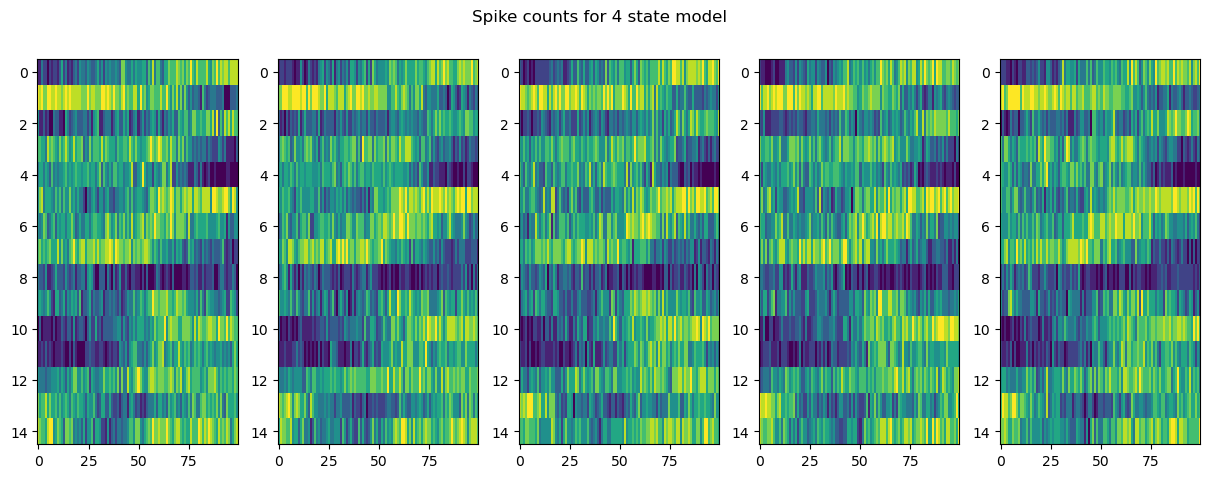

In [7]:
## Visualize some trials
taste_ind = 0
trial_count = 5

imshow_kwargs = dict(interpolation = 'nearest', aspect = 'auto')
fig,ax = plt.subplots(1,trial_count, figsize = (15,5))
for plot_dat, this_ax in zip(shuffle_spikes[taste_ind][:trial_count], ax.flatten()):
    this_ax.imshow(plot_dat, **imshow_kwargs)
plt.suptitle(f'Spike counts for {states} state model');

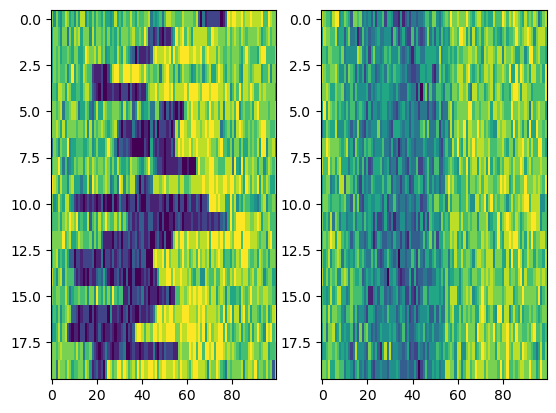

In [8]:
# Single neuron plots
fig,ax = plt.subplots(1,2)
taste_ind = 0
nrn_ind = 14
img_kwargs = dict(aspect='auto', interpolation='nearest')
ax[0].imshow(spike_array[taste_ind,:,nrn_ind], **img_kwargs)
ax[1].imshow(shuffle_spikes[taste_ind,:,nrn_ind], **img_kwargs)

In [57]:
data_list = [spike_array[taste_ind,:,nrn_ind], shuffle_spikes[taste_ind,:,nrn_ind]]

In [51]:
with pm.Model() as model:
    hyper_step = pm.Exponential("hyper_step", 0.05)
    step_size = pm.Exponential("step_size", hyper_step)
    lambda_latent = pm.GaussianRandomWalk("volatility", sigma=step_size, 
                    shape=(trials, length//bin_width)) 
    lambda_ = pm.Deterministic('lambda_', np.exp(lambda_latent))
    rate = pm.Poisson("rate", lambda_, observed=np.stack(data_list[0]))

/home/abuzarmahmood/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/distributions/timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


In [52]:
with model:
    trace = pm.sample(nuts_sampler="numpyro")

Compiling...
Compilation time =  0:00:02.763323
Sampling...


Compiling.. :   0%|                                                                       | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                     | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                       | 0/2000 [00:00<?, ?it/s]


  0%|                                                                                     | 0/2000 [00:00<?, ?it/s]


Compiling.. :   0%|                                                                       | 0/2000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                    | 0/2000 [00:02<?, ?it/s]


Running chain 3:   0%|                                                                    | 0/2000 [00:02<?, ?it/s]

Running chain 0:   5%|██▊                                                      | 100/2000 [00:03<00:12, 154.93it/s]


Running chain 1:   5%|██▊                                   

Sampling time =  0:00:13.317222
Transforming variables...
Transformation time =  0:00:00.245893


In [53]:
ppc_list = pm.sample_posterior_predictive(trace, model = model, var_names = ['lambda_'])

Sampling: []


In [54]:
ppc_list.posterior_predictive.lambda_.shape
mean_ppc = ppc_list.posterior_predictive.lambda_.mean(axis=(0,1))

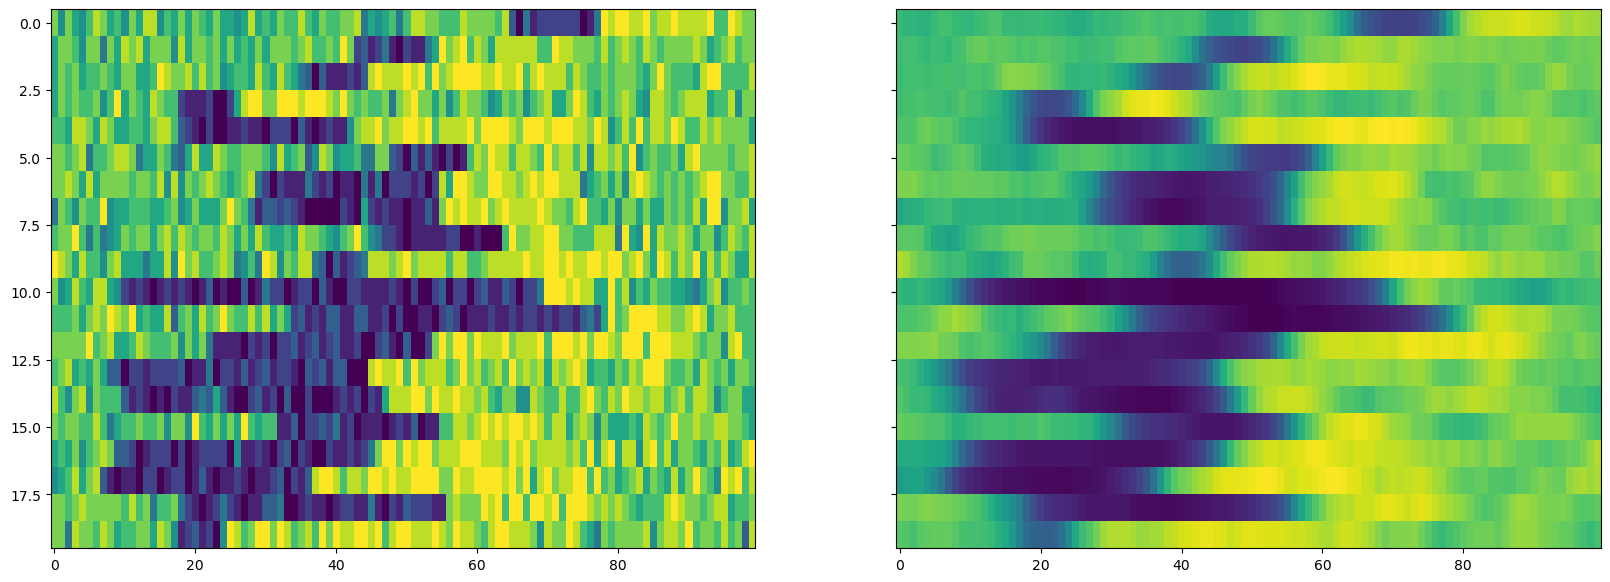

In [56]:
fig, ax = plt.subplots(1,2, figsize = (20,7), sharey = True)
ax[0].imshow(data_list[0], **img_kwargs)
ax[1].imshow(mean_ppc, **img_kwargs);

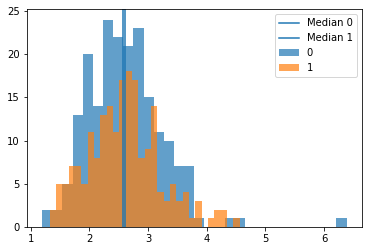

In [129]:
for num, this_trace in enumerate(trace_list):
    plt.hist(this_trace['hyper_step'], alpha = 0.7, label = str(num), bins = 30)
    plt.axvline(np.median(this_trace['hyper_step']), label = f'Median {num}')
plt.legend()